# Imports

In [15]:
import numpy as np
import os
import sys
import pickle
import scipy
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api
import statsmodels as sm
import statsmodels.stats.multitest as smt

## Helper Functions

In [16]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import nodeMapping as nm
import normalize as norm

# Set Directory Paths

In [17]:
# Only used to load the FTDGeneralData_20221114.mat file --> Saved as NetworkDataGeneral
%store -r baseDir

# Directory path to load formatted Pathology Data
%store -r path_dataDir

# Directory path to save Calcualted Analysis Data
%store -r path_CalData

# Directory path to save Figures
%store -r path_Fig

# Loading

## Loading the preconstructed atlas data

In [18]:
# loads the preconstructed Atlas data
NetworkDataGeneral = scipy.io.loadmat(os.path.join(baseDir, 'NetworkAnalysisGeneral', 'FTDGeneralData_20221114.mat'))

## Loading Pathology Data (TAU, TDP) - Dropped

In [19]:
# path_TAU_Drop
with open(os.path.join(path_dataDir, 'path_TAU_Drop.pkl'), 'rb') as f:
    path_TAU_Drop = pickle.load(f)
f.close()

# path_TDP_Drop
with open(os.path.join(path_dataDir, 'path_TDP_Drop.pkl'), 'rb') as f:
    path_TDP_Drop = pickle.load(f)
f.close()

## Loading Dropped Index (=few observations)

In [20]:
# TAU_missing_index
with open(os.path.join(path_CalData, 'TAU_missing_index.pkl'), 'rb') as f:
    TAU_missing_index = pickle.load(f)
f.close()

# TDP_missing_index
with open(os.path.join(path_CalData, 'TDP_missing_index.pkl'), 'rb') as f:
    TDP_missing_index = pickle.load(f)
f.close()

## Loading Pathology Labels (TAU, TDP) - Dropped

In [21]:
# pathNames_TAU_Drop
with open(os.path.join(path_CalData, 'pathNames_TAU_Drop.pkl'), 'rb') as f:
    pathNames_TAU_Drop = pickle.load(f)
f.close()

# pathNames_TDP_Drop
with open(os.path.join(path_CalData, 'pathNames_TDP_Drop.pkl'), 'rb') as f:
    pathNames_TDP_Drop = pickle.load(f)
f.close()

## Loading pathCoM (TAU, TDP) - Dropped

In [22]:
# CoM_TAU_Drop
with open(os.path.join(path_dataDir, 'CoM_TAU_Drop.pkl'), 'rb') as f:
    CoM_TAU_Drop = pickle.load(f)
f.close()

# CoM_TDP_Drop
with open(os.path.join(path_dataDir, 'CoM_TDP_Drop.pkl'), 'rb') as f:
    CoM_TDP_Drop = pickle.load(f)
f.close()

## 01/31/2024

#### Data Distribution

In [23]:
def dist_boxplot(data, labels, min_val, max_val, title, x_label, y_label):
    # Reorder the data and labels (group by regions L, R)
    new_order = [i//2 if i % 2 == 0 else int((i//2) + (len(labels)/2)) for i in range(len(labels))]
    reordered_data = data[:, new_order]
    reordered_labels = [labels[i] for i in new_order]
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create boxplots for each column
    boxplot = sns.boxplot(data=reordered_data, width=0.5, ax=ax, fliersize=0, boxprops=dict(alpha=.3))

    # Add individual data points with aligned x-values
    for i, col_data in enumerate(reordered_data.T):
        # Handle NaNs
        col_data = col_data[~np.isnan(col_data)]

        jitter = np.random.normal(0, 0.1, size=len(col_data))  # Add jitter for better visualization
        x = np.full_like(col_data, i) + jitter
        ax.scatter(x, col_data, alpha=0.5, color='blue', s=5)

     # Add vertical lines every two columns
    for i in range(1, int(len(labels)-2), 2):
        ax.axvline(x=i + 0.5, color='grey', linestyle='--', lw=0.5)
        
    # Set x-axis labels
    ax.set_xticks(np.arange(0, len(labels)))
    ax.set_xticklabels(reordered_labels, rotation=45, ha='right')  # Use NeuN_Labels as x-axis labels

    # Set y-axis limits (replace these values with your desired limits)
    y_min_limit = min_val  # Minimum limit
    y_max_limit = max_val  # Maximum limit
    ax.set_ylim(y_min_limit, y_max_limit)

    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [24]:
# min max
all_values = np.concatenate([path_TAU_Drop.flatten(), path_TDP_Drop.flatten()])
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
buffer = (max_val-min_val) * 0.1

min_val = min_val - buffer
max_val = max_val + buffer

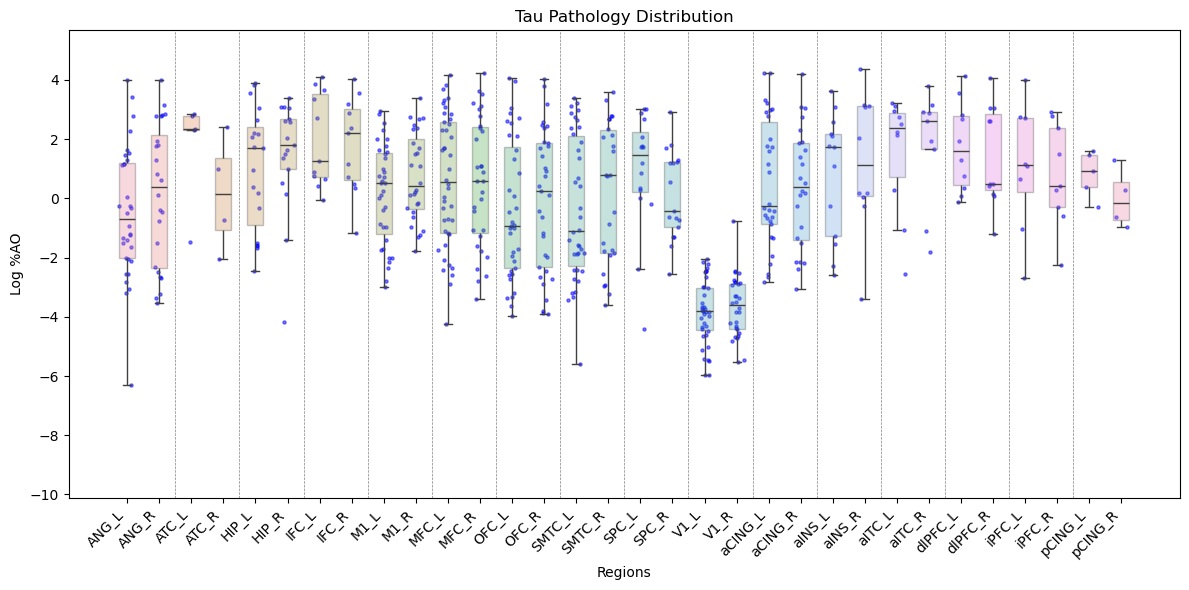

In [25]:
dist_boxplot(path_TAU_Drop, pathNames_TAU_Drop, min_val, max_val, 'Tau Pathology Distribution', 'Regions', 'Log %AO')

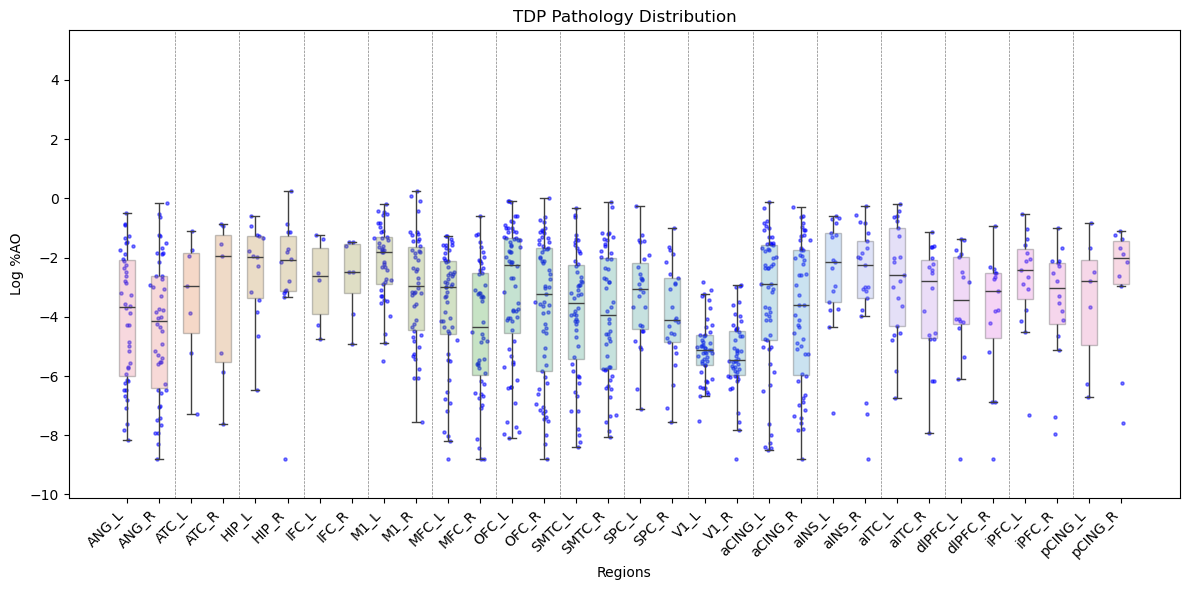

In [26]:
dist_boxplot(path_TDP_Drop, pathNames_TDP_Drop, min_val, max_val, 'TDP Pathology Distribution', 'Regions', 'Log %AO')

In [27]:
# 2-sided test

def t_test_func(left_data, right_data, LabelNames):
    # Perform t-test for each column
    p_values = [stats.ttest_ind(left_data[:, i], right_data[:, i], equal_var=False, nan_policy='omit', alternative='two-sided').pvalue for i in range(left_data.shape[1])]

    # Identifying indices with NaN p-values
    nan_indices = [i for i, p in enumerate(p_values) if p is None or np.isnan(p)]
    valid_indices = [i for i in range(len(p_values)) if i not in nan_indices]
    valid_p_values = [p_values[i] for i in valid_indices]

    # Multiple comparison correction for non-NaN p-values
    corrected_p_values = smt.multipletests(valid_p_values, method='fdr_bh')[1]

    # Initialize a new array with NaNs and replace non-NaN positions with corrected p-values
    final_p_values = np.full(len(p_values), np.nan)
    for i, val in zip(valid_indices, corrected_p_values):
        final_p_values[i] = val

    # Region names for output
    region_names = LabelNames

    # Output the corrected p-values
    for i, p_val in enumerate(final_p_values):
        if np.isnan(p_val):
            print(f"{region_names[i]:<10}: p-value cannot be computed")
        else:
            difference_status = "NOT significantly different" if p_val > 0.05 else "significantly different"
            print(f"{region_names[i]:<10}: Corrected p-value = {p_val:.4f} / {difference_status}")



In [28]:
print("T-Test for Pathology: TAU vs TDP")
t_test_func(path_TAU_Drop, path_TDP_Drop, pathNames_TAU_Drop)

T-Test for Pathology: TAU vs TDP
ANG_L     : Corrected p-value = 0.0000 / significantly different
ATC_L     : Corrected p-value = 0.0014 / significantly different
HIP_L     : Corrected p-value = 0.0000 / significantly different
IFC_L     : Corrected p-value = 0.0001 / significantly different
M1_L      : Corrected p-value = 0.0000 / significantly different
MFC_L     : Corrected p-value = 0.0000 / significantly different
OFC_L     : Corrected p-value = 0.0000 / significantly different
SMTC_L    : Corrected p-value = 0.0000 / significantly different
SPC_L     : Corrected p-value = 0.0000 / significantly different
V1_L      : Corrected p-value = 0.0000 / significantly different
aCING_L   : Corrected p-value = 0.0000 / significantly different
aINS_L    : Corrected p-value = 0.0002 / significantly different
aITC_L    : Corrected p-value = 0.0000 / significantly different
dlPFC_L   : Corrected p-value = 0.0000 / significantly different
iPFC_L    : Corrected p-value = 0.0011 / significantly di

### Normalize each TAU and TDP separately (to range -1, 1)

In [29]:
# Min/Max Range of Normalizing
t_min = -1
t_max = 1

In [30]:
# normalizing TAU EXCLUDING NaN!
path_TAU_Drop_Norm = norm.normalize2d(path_TAU_Drop, t_min, t_max)

In [31]:
# normalizing TDP EXCLUDING NaN!
path_TDP_Drop_Norm = norm.normalize2d(path_TDP_Drop, t_min, t_max)

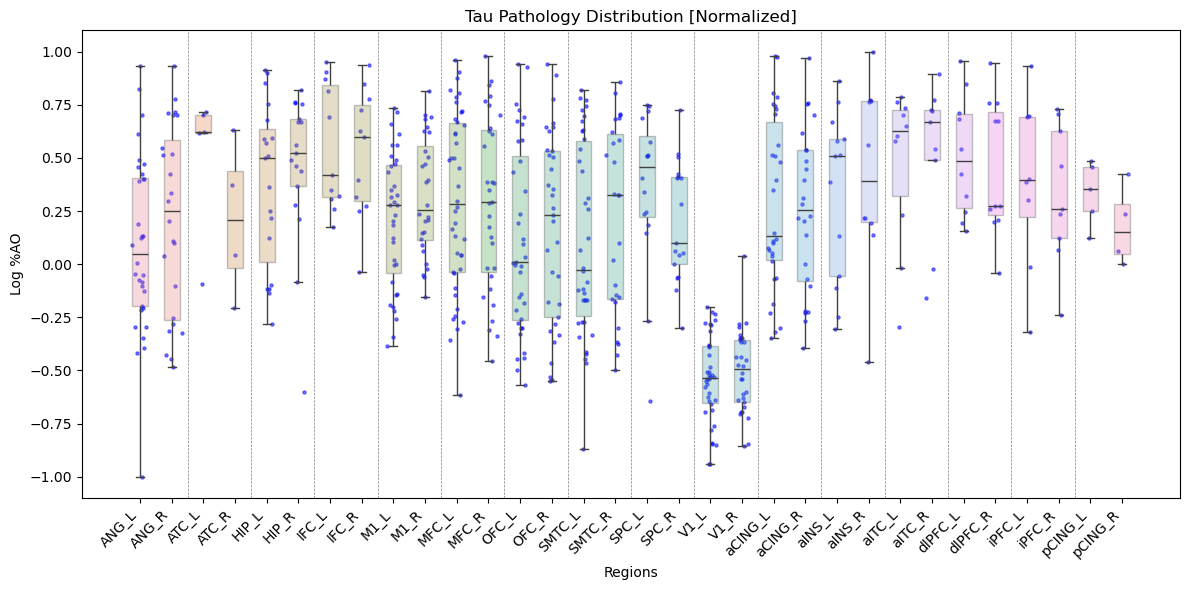

In [35]:
dist_boxplot(path_TAU_Drop_Norm, pathNames_TAU_Drop, -1.1, 1.1, 'Tau Pathology Distribution [Normalized]', 'Regions', 'Log %AO')

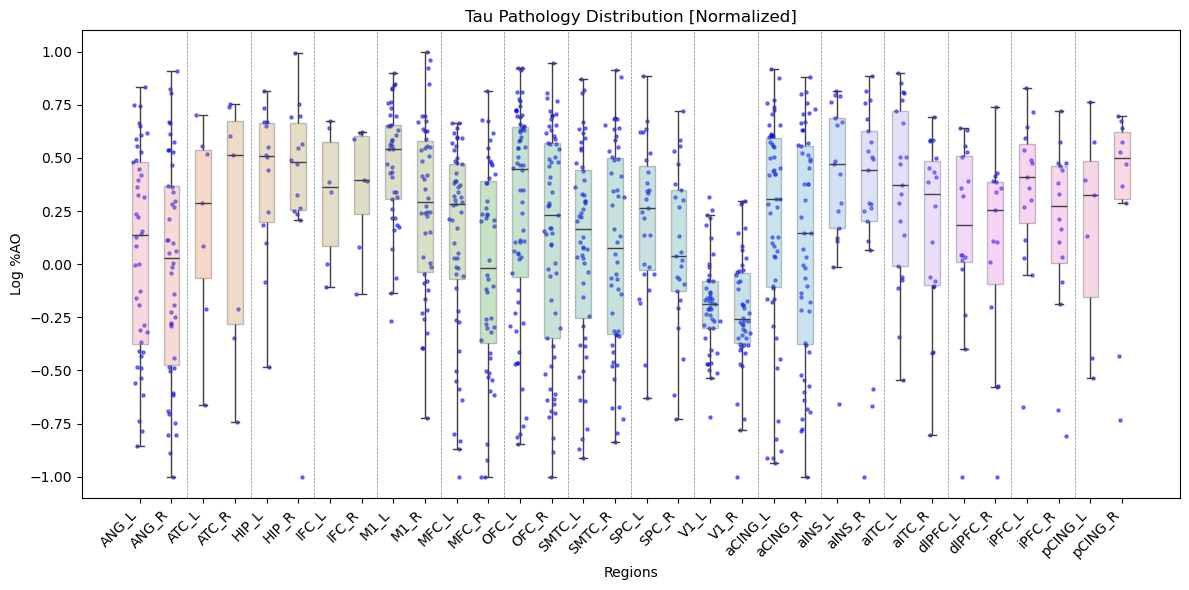

In [34]:
dist_boxplot(path_TDP_Drop_Norm, pathNames_TAU_Drop, -1.1, 1.1, 'Tau Pathology Distribution [Normalized]', 'Regions', 'Log %AO')

In [36]:
print("T-Test for Pathology: TAU vs TDP")
t_test_func(path_TAU_Drop_Norm, path_TDP_Drop_Norm, pathNames_TAU_Drop)

T-Test for Pathology: TAU vs TDP
ANG_L     : Corrected p-value = 0.8650 / NOT significantly different
ATC_L     : Corrected p-value = 0.4597 / NOT significantly different
HIP_L     : Corrected p-value = 0.8983 / NOT significantly different
IFC_L     : Corrected p-value = 0.4597 / NOT significantly different
M1_L      : Corrected p-value = 0.0035 / significantly different
MFC_L     : Corrected p-value = 0.2208 / NOT significantly different
OFC_L     : Corrected p-value = 0.4453 / NOT significantly different
SMTC_L    : Corrected p-value = 0.8654 / NOT significantly different
SPC_L     : Corrected p-value = 0.5267 / NOT significantly different
V1_L      : Corrected p-value = 0.0000 / significantly different
aCING_L   : Corrected p-value = 0.5867 / NOT significantly different
aINS_L    : Corrected p-value = 0.7989 / NOT significantly different
aITC_L    : Corrected p-value = 0.6263 / NOT significantly different
dlPFC_L   : Corrected p-value = 0.1181 / NOT significantly different
iPFC_L   

# T-test between TAU vs TDP

## Checking if there is region differences between TAU and TDP due to Drop in Observations

In [9]:
print(TAU_missing_index)
print(TDP_missing_index)

# --> There is no difference

[ 7  8 17 19 27 28 37 39]
[ 7  8 17 19 27 28 37 39]


In [10]:
# Number of regions of Pathology (N = 40)
N = path_TAU_Drop.shape[1]

## T-test. Since the sample numbers are different between TAU and TDP, we would perform Welch's t-test

In [11]:
TAU_gt_TDP_Ttest_stat_list = []
TAU_gt_TDP_Ttest_pval_list = []

TDP_gt_TAU_Ttest_stat_list = []
TDP_gt_TAU_Ttest_pval_list = []


for i in range(N):
    TAU_data = path_TAU_Drop[:, i]
    TDP_data = path_TDP_Drop[:, i]

    # ignore NaN Values in T-test
    TAU_gt_TDP_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='greater', nan_policy='omit')
    TDP_gt_TAU_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='less', nan_policy='omit')

    TAU_gt_TDP_Ttest_stat = TAU_gt_TDP_Ttest[0]
    TAU_gt_TDP_Ttest_pval = TAU_gt_TDP_Ttest[1]

    TAU_gt_TDP_Ttest_stat_list.append(TAU_gt_TDP_Ttest_stat)
    TAU_gt_TDP_Ttest_pval_list.append(TAU_gt_TDP_Ttest_pval)

    TDP_gt_TAU_Ttest_stat = TDP_gt_TAU_Ttest[0]
    TDP_gt_TAU_Ttest_pval = TDP_gt_TAU_Ttest[1]

    TDP_gt_TAU_Ttest_stat_list.append(TDP_gt_TAU_Ttest_stat)
    TDP_gt_TAU_Ttest_pval_list.append(TDP_gt_TAU_Ttest_pval)
    

## Multiple Comparison Correction / alpha = 0.05 / Method: Benjamini/Hochberg (non-negative)

### Corrected for TAU > TDP

In [12]:
TAU_gt_TDP_reject, TAU_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TAU_gt_TDP_Ttest_pval_list, alpha=0.05,
                                                                                                           method='fdr_bh', is_sorted=False, 
                                                                                                           returnsorted=False)

### Corrected for TDP > TAU

In [13]:
TDP_gt_TAU_reject, TDP_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TDP_gt_TAU_Ttest_pval_list, alpha=0.05,
                                                                                                          method='fdr_bh', is_sorted=False, 
                                                                                                          returnsorted=False)

## TAU > TDP

In [14]:
# Pandas DataFrame
TAU_gt_TDP_df = pd.DataFrame(np.concatenate((np.array(TAU_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TAU_gt_TDP_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TAU_Drop)

TAU_gt_TDP_df['Result'] = TAU_gt_TDP_df['Result'].astype('bool')

In [15]:
TAU_gt_TDP_df

,corrected pval,Result
ANG_L,3.899843e-09,True
ATC_L,7.103142e-04,True
HIP_L,5.156948e-06,True
IFC_L,3.516484e-05,True
M1_L,1.680535e-08,True
MFC_L,2.812864e-14,True
OFC_L,2.370096e-07,True
SMTC_L,1.605450e-09,True
SPC_L,1.659683e-07,True
V1_L,2.786328e-07,True


## TDP > TAU

In [16]:
# Pandas DataFrame
TDP_gt_TAU_df = pd.DataFrame(np.concatenate((np.array(TDP_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TDP_gt_TAU_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TDP_Drop)

TDP_gt_TAU_df['Result'] = TDP_gt_TAU_df['Result'].astype('bool')

In [17]:
TDP_gt_TAU_df

,corrected pval,Result
ANG_L,1.0,False
ATC_L,1.0,False
HIP_L,1.0,False
IFC_L,1.0,False
M1_L,1.0,False
MFC_L,1.0,False
OFC_L,1.0,False
SMTC_L,1.0,False
SPC_L,1.0,False
V1_L,1.0,False


## Normalize the values between TAU and TDP

# Get Min/Max of TAU and TDP Data

In [18]:
# Max, Min value of TAU
max_TAU = np.nanmax(path_TAU_Drop)
min_TAU = np.nanmin(path_TAU_Drop)
print(max_TAU)
print(min_TAU)

4.360727024958423
-6.292569639891903


In [19]:
# Max, Min value of TDP
max_TDP = np.nanmax(path_TDP_Drop)
min_TDP = np.nanmin(path_TDP_Drop)
print(max_TDP)
print(min_TDP)

0.2570987841537611
-8.804875263868018


## Distribution of Original TAU and TDP Values

### Distribution ot TAU

Text(0.5, 1.0, 'TAU Distribution')

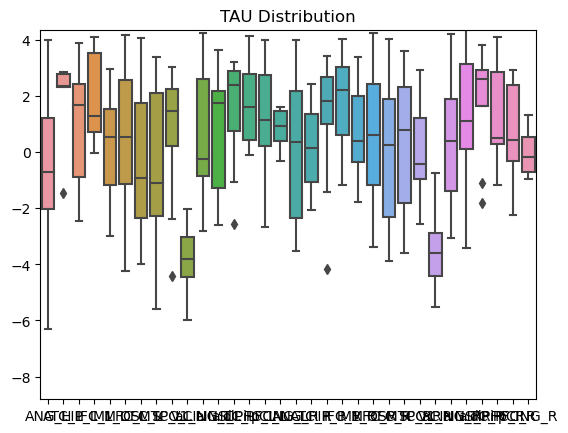

In [20]:
# Convert ndarray into pandas dataframe
path_TAU_Drop_df = pd.DataFrame(path_TAU_Drop, columns = pathNames_TAU_Drop)
# Set the figure size
# plt.rcParams["figure.figsize"] = [20, 7]
# plt.rcParams["figure.autolayout"] = True
# sns.set_style("whitegrid")
# Draw the boxplot
ax = sns.boxplot(data=path_TAU_Drop_df)
# Set the y-axis range eqaul (min, max of TAU and TDP combined)
ax.set_ylim((min(min_TAU, min_TDP), max(max_TAU, max_TDP)))
ax.set_title("TAU Distribution")

### Distribution ot TDP


Text(0.5, 1.0, 'TDP Distribution')

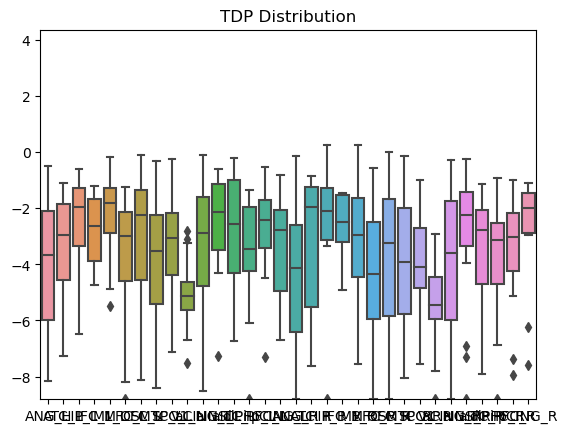

In [21]:
# Convert ndarray into pandas dataframe
path_TDP_Drop_df = pd.DataFrame(path_TDP_Drop, columns = pathNames_TDP_Drop)
# Set the figure size
# plt.rcParams["figure.figsize"] = [20, 7]
# plt.rcParams["figure.autolayout"] = True
# sns.set_style("whitegrid")
# Draw the boxplot
ax = sns.boxplot(data=path_TDP_Drop_df)
# Set the y-axis range eqaul (min, max of TAU and TDP combined)
ax.set_ylim((min(min_TAU, min_TDP), max(max_TAU, max_TDP)))
ax.set_title("TDP Distribution")

### Normalize each TAU and TDP separately (to range -1, 1)

In [22]:
# Min/Max Range of Normalizing
t_min = -1
t_max = 1

In [23]:
# normalizing TAU EXCLUDING NaN!
path_TAU_Drop_Norm = norm.normalize2d(path_TAU_Drop, t_min, t_max)

In [24]:
# normalizing TDP EXCLUDING NaN!
path_TDP_Drop_Norm = norm.normalize2d(path_TDP_Drop, t_min, t_max)

## Distribution after Normalization

### TAU

Text(0.5, 1.0, 'TAU After Normalization Distribution')

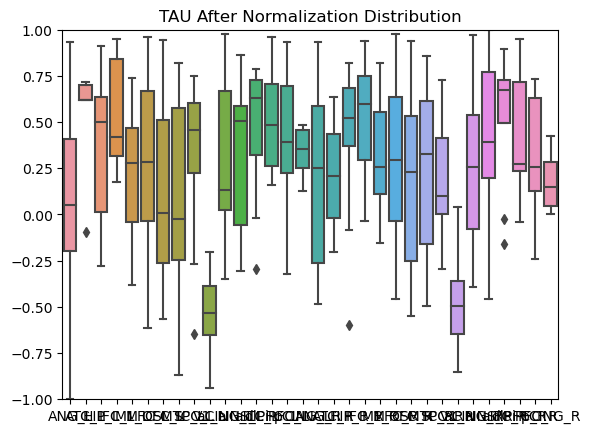

In [25]:
# Convert ndarray into pandas dataframe
path_TAU_Drop_norm_df = pd.DataFrame(path_TAU_Drop_Norm, columns = pathNames_TAU_Drop)
# Set the figure size
# plt.rcParams["figure.figsize"] = [20, 7]
# plt.rcParams["figure.autolayout"] = True
# sns.set_style("whitegrid")
# Draw the boxplot
ax = sns.boxplot(data=path_TAU_Drop_norm_df)
# Set the y-axis range eqaul (min, max of TAU and TDP combined)
ax.set_ylim((-1, 1))
ax.set_title("TAU After Normalization Distribution")

### TDP

Text(0.5, 1.0, 'TDP After Normalization Distribution')

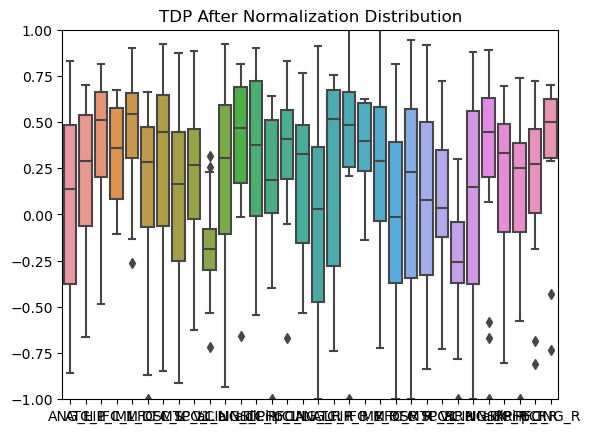

In [26]:
# Convert ndarray into pandas dataframe
path_TDP_Drop_norm_df = pd.DataFrame(path_TDP_Drop_Norm, columns = pathNames_TDP_Drop)
# Set the figure size
# plt.rcParams["figure.figsize"] = [20, 7]
# plt.rcParams["figure.autolayout"] = True
# sns.set_style("whitegrid")
# Draw the boxplot
ax = sns.boxplot(data=path_TDP_Drop_norm_df)
# Set the y-axis range eqaul (min, max of TAU and TDP combined)
ax.set_ylim((-1, 1))
ax.set_title("TDP After Normalization Distribution")

## T-test. Since the sample numbers are different between TAU and TDP, we would perform Welch's t-test

In [27]:
TAU_gt_TDP_Ttest_stat_list_Norm = []
TAU_gt_TDP_Ttest_pval_list_Norm = []

TDP_gt_TAU_Ttest_stat_list_Norm = []
TDP_gt_TAU_Ttest_pval_list_Norm = []


for i in range(N):
    TAU_data = path_TAU_Drop_Norm[:, i]
    TDP_data = path_TDP_Drop_Norm[:, i]

    # ignore NaN Values in T-test / eqaul_var = False --> Welch's T-Test
    TAU_gt_TDP_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='greater', nan_policy='omit')
    TDP_gt_TAU_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='less', nan_policy='omit')

    TAU_gt_TDP_Ttest_stat = TAU_gt_TDP_Ttest[0]
    TAU_gt_TDP_Ttest_pval = TAU_gt_TDP_Ttest[1]

    TAU_gt_TDP_Ttest_stat_list_Norm.append(TAU_gt_TDP_Ttest_stat)
    TAU_gt_TDP_Ttest_pval_list_Norm.append(TAU_gt_TDP_Ttest_pval)

    TDP_gt_TAU_Ttest_stat = TDP_gt_TAU_Ttest[0]
    TDP_gt_TAU_Ttest_pval = TDP_gt_TAU_Ttest[1]

    TDP_gt_TAU_Ttest_stat_list_Norm.append(TDP_gt_TAU_Ttest_stat)
    TDP_gt_TAU_Ttest_pval_list_Norm.append(TDP_gt_TAU_Ttest_pval)
    

## Multiple Comparison Correction / alpha = 0.05 / Method: Benjamini/Hochberg (non-negative)

### Corrected for TAU > TDP

In [28]:
TAU_gt_TDP_reject_norm, TAU_gt_TDP_pvals_corrected_norm, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TAU_gt_TDP_Ttest_pval_list_Norm, alpha=0.05,
                                                                                                           method='fdr_bh', is_sorted=False, 
                                                                                                           returnsorted=False)

### Corrected for TDP > TAU

In [29]:
TDP_gt_TAU_reject_norm, TDP_gt_TDP_pvals_corrected_norm, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TDP_gt_TAU_Ttest_pval_list_Norm, alpha=0.05,
                                                                                                          method='fdr_bh', is_sorted=False, 
                                                                                                          returnsorted=False)

## TAU > TDP

In [30]:
# Generage DataFrame of results
TAU_gt_TDP_Norm_df = pd.DataFrame(np.concatenate((np.array(TAU_gt_TDP_pvals_corrected_norm).reshape((-1, 1)), 
                                                  np.array(TAU_gt_TDP_reject_norm).reshape((-1, 1))), axis=1), 
                                                  columns=['corrected pval', 'Result'], index=pathNames_TAU_Drop)
# Make Results to boolean
TAU_gt_TDP_Norm_df['Result'] = TAU_gt_TDP_Norm_df['Result'].astype('bool')

In [31]:
TAU_gt_TDP_Norm_df

,corrected pval,Result
ANG_L,0.540844,False
ATC_L,0.321757,False
HIP_L,0.695223,False
IFC_L,0.321757,False
M1_L,1.000000,False
MFC_L,0.176573,False
OFC_L,1.000000,False
SMTC_L,0.540844,False
SPC_L,0.345491,False
V1_L,1.000000,False


## TDP > TAU

In [32]:
# Generage DataFrame of results
TDP_gt_TAU_Norm_df = pd.DataFrame(np.concatenate((np.array(TDP_gt_TDP_pvals_corrected_norm).reshape((-1, 1)), 
                                                  np.array(TDP_gt_TAU_reject_norm).reshape((-1, 1))), axis=1), 
                                                  columns=['corrected pval', 'Result'], index=pathNames_TDP_Drop)
# Make Results boolean
TDP_gt_TAU_Norm_df['Result'] = TDP_gt_TAU_Norm_df['Result'].astype('bool')

In [33]:
TDP_gt_TAU_Norm_df

,corrected pval,Result
ANG_L,9.982575e-01,False
ATC_L,9.982575e-01,False
HIP_L,9.982575e-01,False
IFC_L,9.982575e-01,False
M1_L,1.771424e-03,True
MFC_L,9.982575e-01,False
OFC_L,6.122623e-01,False
SMTC_L,9.982575e-01,False
SPC_L,9.982575e-01,False
V1_L,7.420017e-10,True


# Save T-test results as csv

In [34]:
# Original
TAU_gt_TDP_df.to_csv(path_Fig + '/TAU_gt_TDP_Ttest.csv(Log%AO)', index=True)

TDP_gt_TAU_df.to_csv(path_Fig + '/TDP_gt_TAU_Ttest.csv(Log%AO)', index=True)

# Normalized
TAU_gt_TDP_Norm_df.to_csv(path_Fig + '/TAU_gt_TDP_Ttest(Normalized)(Log%AO).csv', index=True)

TDP_gt_TAU_Norm_df.to_csv(path_Fig + '/TDP_gt_TAU_Ttest(Normalized)(Log%AO).csv', index=True)

# 3D Nodes Mapping of Log %AO

### Define Vectors for Node Size and Node Color

In [35]:
# Log %AO of FTD TAU vs TDP
path_TAU_exp = path_TAU_Drop.copy()
path_TDP_exp = path_TDP_Drop.copy()

# Get min/max %AO TAU/TDP
minPath_TAU = np.nanmin(path_TAU_exp, axis=0)
maxPath_TAU = np.nanmax(path_TAU_exp - minPath_TAU + 0.0015, axis=0)

minPath_TDP = np.nanmin(path_TDP_exp, axis=0)
maxPath_TDP = np.nanmax(path_TDP_exp - minPath_TDP + 0.0015, axis=0)

#### Currently not doing Normalization ####
# Size of Nodes --> Marker
markerVecTAU = np.nanmean(path_TAU_exp, axis=0)
markerVecTAU = 3 * ((markerVecTAU - minPath_TAU) / maxPath_TAU)

markerVecTDP = np.nanmean(path_TDP_exp, axis=0)
markerVecTDP = 3 * ((markerVecTDP - minPath_TDP) / maxPath_TDP)

# Node color 
# --> If Null Hypothesis rejected: 4
# --> If Null Hypothesis cannotbe rejected: 1
colorVecTAU = np.where(TAU_gt_TDP_reject.astype('int') + 1 == 2, 4, TAU_gt_TDP_reject.astype('int') + 1)
colorVecTDP = np.where(TDP_gt_TAU_reject.astype('int') + 1 == 2, 4, TDP_gt_TAU_reject.astype('int') + 1)

#### Formatting boxplot above can cause the 3d mesh to disappear!!!

## TAU

/Users/hyroh/Desktop/FTD_Research/mBIN/FTD_JupyterNotebook/HelperFunctions/Analysis_HelperFuntions/nodeMapping.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # Makes the mapping tighter --> Bigger


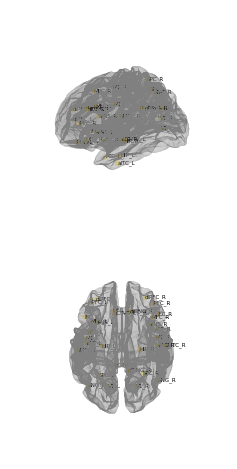

In [36]:
nm.nodeMapping(NetworkDataGeneral, CoM_TAU_Drop, pathNames_TAU_Drop, markerVecTAU, colorVecTAU, path_Fig, 
               'Node_3D_Mapping_TAU', nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)

## TDP

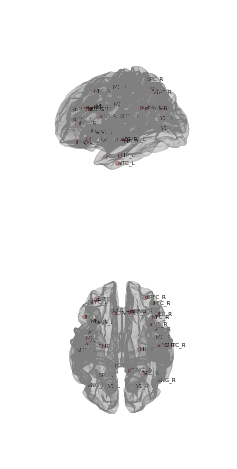

In [37]:
nm.nodeMapping(NetworkDataGeneral, CoM_TDP_Drop, pathNames_TDP_Drop, markerVecTDP, colorVecTDP, path_Fig, 
               'Node_3D_Mapping_TDP', nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)

# For Normalized One

In [38]:
# Log %AO of FTD TAU vs TDP
path_TAU_exp = path_TAU_Drop_Norm.copy()
path_TDP_exp = path_TDP_Drop_Norm.copy()

# Get min/max %AO TAU/TDP
minPath_TAU = np.nanmin(path_TAU_exp, axis=0)
maxPath_TAU = np.nanmax(path_TAU_exp - minPath_TAU + 0.0015, axis=0)

minPath_TDP = np.nanmin(path_TDP_exp, axis=0)
maxPath_TDP = np.nanmax(path_TDP_exp - minPath_TDP + 0.0015, axis=0)

#### Currently not doing Normalization ####
# Size of Nodes --> Marker
markerVecTAU = np.nanmean(path_TAU_exp, axis=0)
markerVecTAU = 3 * ((markerVecTAU - minPath_TAU) / maxPath_TAU)

markerVecTDP = np.nanmean(path_TDP_exp, axis=0)
markerVecTDP = 3 * ((markerVecTDP - minPath_TDP) / maxPath_TDP)

# Node color
# --> If Null Hypothesis rejected: 4
# --> If Null Hypothesis cannotbe rejected: 1
colorVecTAU = np.where(TAU_gt_TDP_reject_norm.astype('int') + 1 == 2, 4, TAU_gt_TDP_reject_norm.astype('int') + 1)
colorVecTDP = np.where(TDP_gt_TAU_reject_norm.astype('int') + 1 == 2, 4, TDP_gt_TAU_reject_norm.astype('int') + 1)

## TAU

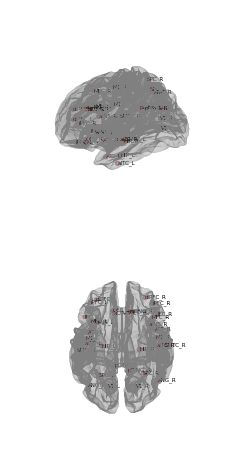

In [39]:
nm.nodeMapping(NetworkDataGeneral, CoM_TAU_Drop, pathNames_TAU_Drop, markerVecTAU, colorVecTAU, path_Fig, 'Node_3D_Mapping_TAU(Normalized)',
                 nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)

## TDP

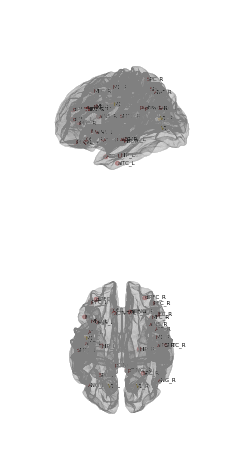

In [40]:
nm.nodeMapping(NetworkDataGeneral, CoM_TDP_Drop, pathNames_TDP_Drop, markerVecTDP, colorVecTDP, path_Fig, 'Node_3D_Mapping_TDP(Normalized)',
                 nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)